In [1]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio
import zipfile
import os

# Load from Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

zip_path = '/content/drive/MyDrive/Speech_Emotion_Recogntion/audio_src/combined_dataset.zip'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/')

Mounted at /content/drive


# Test on 1 random file

Sample rate : 44100
Original audio :


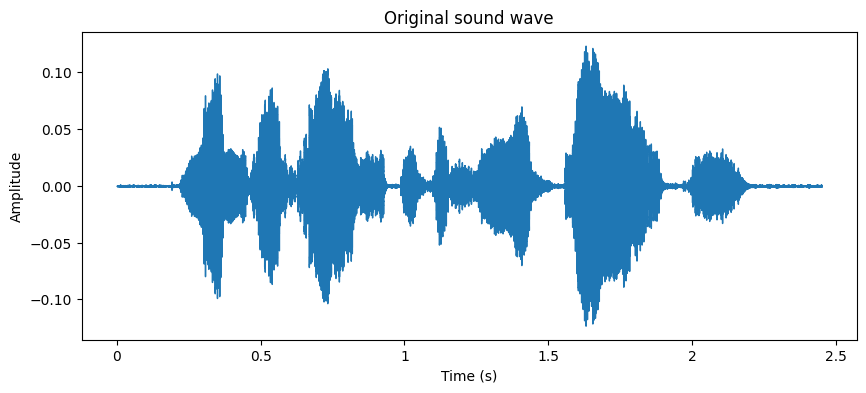

Audio after padding :


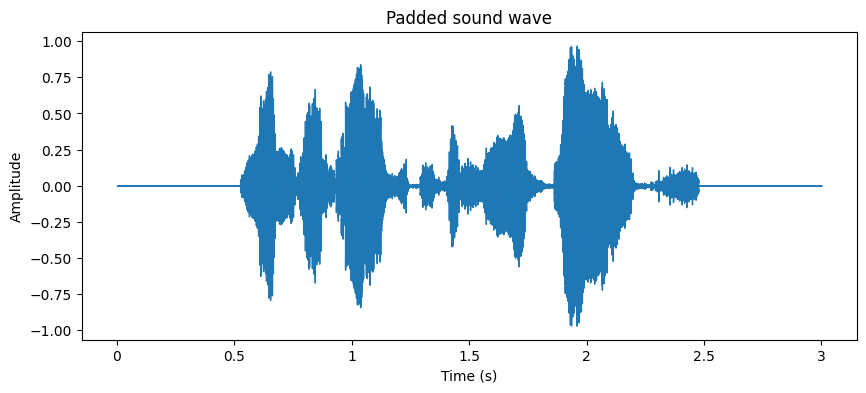

In [3]:
file_path = "/content/combined_dataset/JL_angry_58.wav"
y, sr = librosa.load(file_path, sr=None)  # Load with native sample rate

print("Sample rate : " + str(sr))

# Play original audio
print("Original audio :")
display(Audio(y, rate=sr))

# Show original sound wave
plt.figure(figsize=(10, 4))
librosa.display.waveshow(y, sr=sr)
plt.title("Original sound wave")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

# Normalization based on maximum amplitude
y_normalized = y / np.max(np.abs(y))

# Remove silence from the beginning and end
y_trimmed, index = librosa.effects.trim(y_normalized, top_db=20)

# Resampling at 16000 Hz
target_sr = 16000
y_resampled = librosa.resample(y_trimmed, orig_sr=sr, target_sr=target_sr)

# Calculate target length (3 seconds)
target_length = target_sr * 3  # 3 seconds

# Calculate how much padding is needed at the start and end
current_length = len(y_resampled)
padding_length = target_length - current_length

if padding_length > 0:
    # Split padding equally between start and end
    pad_start = padding_length // 2
    pad_end = padding_length - pad_start

    # Add padding at the start and end
    y_padded = np.pad(y_resampled, (pad_start, pad_end), mode='constant')
else:
    # If audio is longer than 3 seconds, crop it
    y_padded = y_resampled[:target_length]

# Play audio after padding
print("Audio after padding :")
display(Audio(y_padded, rate=target_sr))

# Show padded sound wave
plt.figure(figsize=(10, 4))
librosa.display.waveshow(y_padded, sr=target_sr)
plt.title("Padded sound wave")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

In [5]:
def preprocess_audio(file_path, target_duration=3, target_sr=16000):
    """
    Charge un fichier audio, enlève les silences, le rééchantillonne,
    et ajoute du padding pour que la durée soit égale à target_duration (en secondes).

    Args:
    - file_path (str): Le chemin du fichier audio.
    - target_duration (float): La durée cible de l'audio en secondes.
    - target_sr (int): Le taux d'échantillonnage cible pour l'audio.

    Returns:
    - y_padded (numpy.ndarray): L'audio traité avec padding ajouté si nécessaire.
    """
    # Charger l'audio
    y, sr = librosa.load(file_path, sr=None)  # Charger avec le taux d'échantillonnage natif

    # Normalisation basée sur l'amplitude maximale
    y_normalized = y / np.max(np.abs(y))

    # Suppression des silences au début et à la fin
    y_trimmed, index = librosa.effects.trim(y_normalized, top_db=20)

    # Rééchantillonnage à target_sr
    y_resampled = librosa.resample(y_trimmed, orig_sr=sr, target_sr=target_sr)

    # Calcul de la durée cible en nombre d'échantillons
    target_length = target_sr * target_duration  # Durée cible en nombre d'échantillons
    current_length = len(y_resampled)
    padding_length = target_length - current_length

    if padding_length > 0:
        # Répartition du padding entre le début et la fin
        pad_start = padding_length // 2
        pad_end = padding_length - pad_start

        # Ajouter du padding au début et à la fin
        y_padded = np.pad(y_resampled, (pad_start, pad_end), mode='constant')
    else:
        # Si l'audio est plus long que la durée cible, on le coupe
        y_padded = y_resampled[:target_length]

    return y_padded, target_sr



def generate_spectrogram(y, sr, output_file):
    """
    Génère un spectrogramme Mel sans bords noirs ni compression
    et l'enregistre en PNG.
    """
    # Calculer le spectrogramme Mel
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
    S_db = librosa.power_to_db(S, ref=np.max)

    # Déterminer la taille optimale pour le spectrogramme
    plt.figure(figsize=(S_db.shape[1] / 100, S_db.shape[0] / 100), dpi=100)
    plt.axis('off')  # Supprimer les axes
    librosa.display.specshow(S_db, sr=sr, fmax=8000, x_axis=None, y_axis=None)

    # Sauvegarder le spectrogramme avec un cadre parfaitement ajusté
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)  # Éliminer les marges
    plt.savefig(output_file, bbox_inches='tight', pad_inches=0, dpi=100, transparent=True)
    plt.close()

In [6]:
# Dossier contenant les fichiers du dataset combiné
input_dir = "/content/combined_dataset/"  # Modifier ce chemin pour le répertoire combined_dataset
output_dir = "/content/drive/MyDrive/Speech_Emotion_Recognition/audio_representations"  # Dossier où les spectrogrammes seront enregistrés

# Créer le dossier de sortie s'il n'existe pas
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Parcourir les fichiers dans le dossier combined_dataset
for root, dirs, files in os.walk(input_dir):
    for file in files:
        if file.endswith('.wav'):
            # Obtenir le chemin du fichier audio
            file_path = os.path.join(root, file)

            try:
                # Appeler la fonction preprocess_audio pour prétraiter l'audio
                y_padded, sr = preprocess_audio(file_path)

                # Générer le chemin du fichier de sortie pour le spectrogramme
                output_file = os.path.join(output_dir, file.replace('.wav', '.png'))

                # Appeler la fonction generate_spectrogram pour créer et sauvegarder le spectrogramme
                generate_spectrogram(y_padded, sr, output_file)

                print(f"Spectrogramme généré et sauvegardé : {output_file}")

            except Exception as e:
                print(f"Erreur avec le fichier {file_path}: {e}")


Spectrogramme généré et sauvegardé : /content/drive/MyDrive/Speech_Emotion_Recognition/audio_representations/RAVDESS_fearful_52.png
Spectrogramme généré et sauvegardé : /content/drive/MyDrive/Speech_Emotion_Recognition/audio_representations/ESD_sad_1.png
Spectrogramme généré et sauvegardé : /content/drive/MyDrive/Speech_Emotion_Recognition/audio_representations/RAVDESS_fearful_6.png
Spectrogramme généré et sauvegardé : /content/drive/MyDrive/Speech_Emotion_Recognition/audio_representations/SAVEE_surprise_128.png
Spectrogramme généré et sauvegardé : /content/drive/MyDrive/Speech_Emotion_Recognition/audio_representations/RAVDESS_angry_17.png
Spectrogramme généré et sauvegardé : /content/drive/MyDrive/Speech_Emotion_Recognition/audio_representations/TESS_surprise_81.png
Spectrogramme généré et sauvegardé : /content/drive/MyDrive/Speech_Emotion_Recognition/audio_representations/JL_happy_178.png
Spectrogramme généré et sauvegardé : /content/drive/MyDrive/Speech_Emotion_Recognition/audio_rep